CUDA Convolutional Sparse Coding
================================

This example demonstrates the use of the interface to the CUDA CSC solver extension package, with a test for the availablity of a GPU that runs the Python version of the ConvBPDN solver if one is not available, or if the extension package is not installed.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import plot
plot.config_notebook_plotting()
from sporco import cuda
from sporco.admm import cbpdn
import sporco.linalg as spl
import sporco.metric as spm

# If running in a notebook, try to use wurlitzer so that output from the CUDA
# code will be properly captured in the notebook.
sys_pipes = util.notebook_system_output()

Load example image.

In [2]:
img = util.ExampleImages().image('barbara.png', scaled=True, gray=True,
                                 idxexp=np.s_[10:522, 100:612])

Highpass filter example image.

In [3]:
npd = 16
fltlmbd = 20
sl, sh = util.tikhonov_filter(img, fltlmbd, npd)

Load dictionary.

In [4]:
D = util.convdicts()['G:12x12x36']

Set up [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) options.

In [5]:
lmbda = 1e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 250,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False})

If GPU available, run CUDA ConvBPDN solver, otherwise run standard Python version.

In [6]:
if cuda.device_count() > 0:
    print('%s GPU found: running CUDA solver' % cuda.device_name())
    tm = util.Timer()
    with sys_pipes(), util.ContextTimer(tm):
        X = cuda.cbpdn(D, sh, lmbda, opt)
    t = tm.elapsed()
else:
    print('GPU not found: running Python solver')
    c = cbpdn.ConvBPDN(D, sh, lmbda, opt)
    X = c.solve().squeeze()
    t = c.timer.elapsed('solve')
print('Solve time: %.2f s' % t)

Tesla K40c GPU found: running CUDA solver


Itn   Fnc       DFid      Regℓ1     r         s         ρ
----------------------------------------------------------------
   0  1.07e+02  2.61e+00  1.05e+04  6.43e-01  7.75e-01  1.50e+00
   1  9.36e+01  4.78e+00  8.88e+03  3.34e-01  5.82e-01  1.50e+00
   2  1.11e+02  3.79e+00  1.07e+04  3.21e-01  3.54e-01  1.11e+00
   3  8.82e+01  3.66e+00  8.46e+03  2.50e-01  2.96e-01  1.11e+00
   4  7.80e+01  3.86e+00  7.41e+03  2.20e-01  1.94e-01  9.91e-01
   5  7.61e+01  4.02e+00  7.21e+03  1.64e-01  1.50e-01  9.91e-01
   6  7.26e+01  4.02e+00  6.86e+03  1.28e-01  1.33e-01  9.91e-01
   7  6.89e+01  3.94e+00  6.50e+03  1.05e-01  1.12e-01  9.91e-01
   8  6.65e+01  3.88e+00  6.26e+03  8.82e-02  1.00e-01  9.91e-01
   9  6.40e+01  3.89e+00  6.01e+03  8.00e-02  8.61e-02  9.04e-01
  10  6.14e+01  3.93e+00  5.74e+03  6.83e-02  7.38e-02  9.04e-01
  11  6.03e+01  3.96e+00  5.64e+03  5.83e-02  6.77e-02  9.04e-01
  12  5.99e+01  3.95e+00  5.60e+03  5.41e-02  6.09e-02  8.17e-01
  13  5.90e+01  3.91e+00  5.51e+

Solve time: 1.60 s


Reconstruct the image from the sparse representation.

In [7]:
shr = np.sum(spl.fftconv(D, X), axis=2)
imgr = sl + shr
print("Reconstruction PSNR: %.2fdB\n" % spm.psnr(img, imgr))

Reconstruction PSNR: 44.30dB



Display representation and reconstructed image.

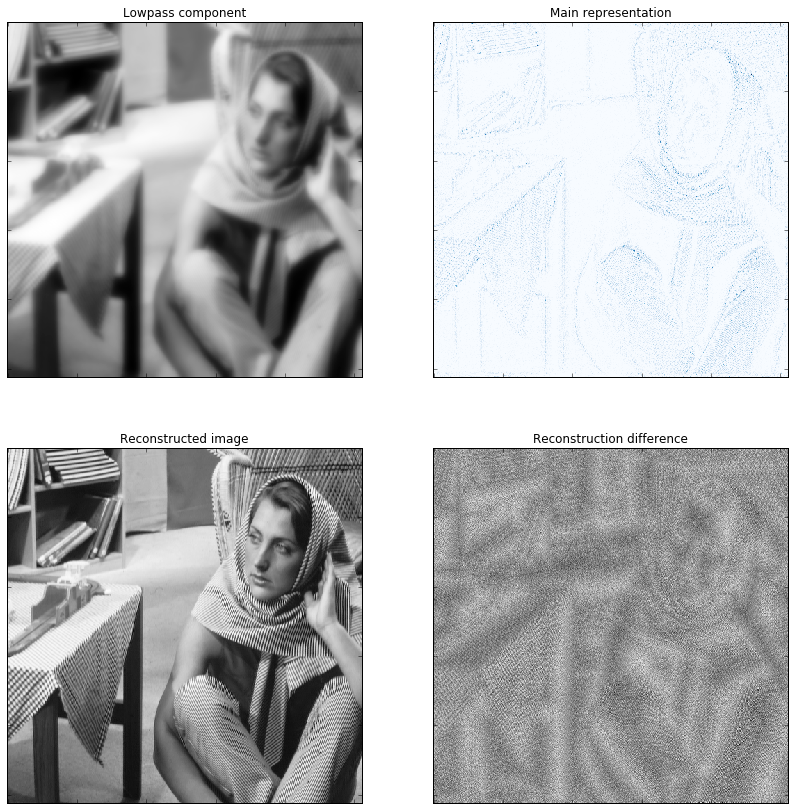

In [8]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(sl, title='Lowpass component', fig=fig)
plot.subplot(2, 2, 2)
plot.imview(np.sum(abs(X), axis=2).squeeze(),
            cmap=plot.cm.Blues, title='Main representation', fig=fig)
plot.subplot(2, 2, 3)
plot.imview(imgr, title='Reconstructed image', fig=fig)
plot.subplot(2, 2, 4)
plot.imview(imgr - img, fltscl=True, title='Reconstruction difference',
            fig=fig)
fig.show()